# Projet final : 1 Etude de texte par Big Data

Étudiez *Les Misérables* en utilisant les techniques de Big Data, identifiez les personnages principaux, analysez les sections où ils sont les plus présents, générez des visuels détaillés et rédigez un compte rendu expliquant vos manipulations, résultats et observations.

# Identification des personnages dans *Les Misérables* avec Big Data

Ce script extrait le texte du roman depuis **Gutenberg**, identifie les personnages avec **spaCy** et affiche un **graphique des plus mentionnés**.  

## Étapes :  
1. **Extraction** : Récupération et nettoyage du texte (**BeautifulSoup**).  
2. **Analyse** : Détection des noms (**spaCy**).  
3. **Visualisation** : Affichage d’un graphique (**Matplotlib**).  

📌 Résultat : un **top 10 des personnages les plus cités**. 

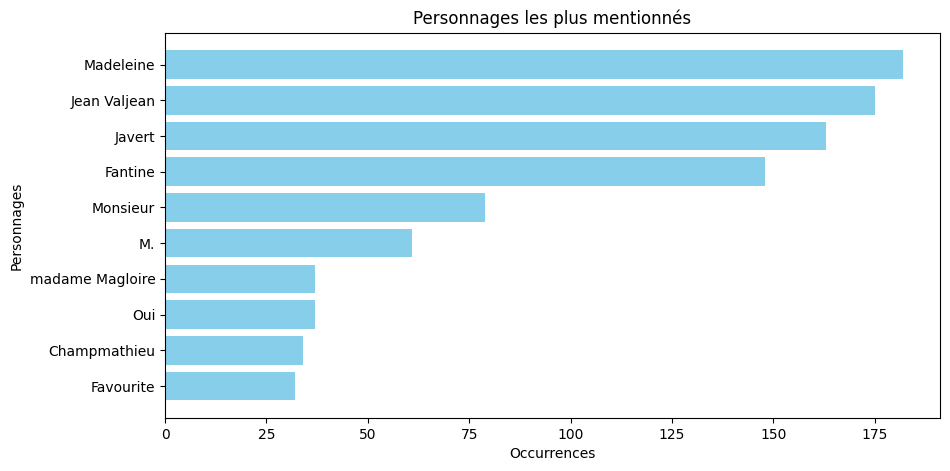

In [16]:
# Question 1: Extraction et analyse du texte des Misérables
import requests
from bs4 import BeautifulSoup
import spacy
from collections import Counter
import matplotlib.pyplot as plt



def extract_miserables_from_gutenberg():
    """Charge et extrait le texte des Misérables depuis Gutenberg"""
    url = "https://www.gutenberg.org/files/17489/17489-h/17489-h.htm"
    try:
        response = requests.get(url)
        response.raise_for_status()
        response.encoding = 'utf-8'
    except requests.RequestException as e:
        print(f"Erreur de chargement : {e}")
        return ""
    
    soup = BeautifulSoup(response.content, 'html.parser')
    start_marker = "Livre premier—Un juste"
    end_marker = "End of the Project Gutenberg EBook of Les misérables Tome I, by Victor Hugo"
    start_tag, end_tag = None, None

    for tag in soup.find_all():
        if start_marker in tag.text:
            start_tag = tag
        if end_marker in tag.text:
            end_tag = tag
        if start_tag and end_tag:
            break

    if start_tag is None or end_tag is None:
        print("Marqueurs introuvables")
        return ""

    text_content = []
    current_tag = start_tag.find_next()
    while current_tag and current_tag != end_tag:
        if current_tag.name == 'p':
            text_content.append(current_tag.get_text(strip=True))
        current_tag = current_tag.find_next()

    return "\n".join(text_content)

def extract_character_names(text):
    """Utilise spaCy pour identifier les personnages"""
    nlp = spacy.load("fr_core_news_sm")
    doc = nlp(text)
    names = [ent.text for ent in doc.ents if ent.label_ == "PER"]
    return Counter(names)

# Extraction des personnages
txt_data = extract_miserables_from_gutenberg()
if txt_data:
    character_counts = extract_character_names(txt_data)
    top_characters = character_counts.most_common(10)
    
    plt.figure(figsize=(10,5))
    plt.barh(*zip(*top_characters), color='skyblue')
    plt.xlabel("Occurrences")
    plt.ylabel("Personnages")
    plt.title("Personnages les plus mentionnés")
    plt.gca().invert_yaxis()
    plt.show()

## Analyse des personnages dans *Les Misérables* avec Big Data

Ce code crée une classe `MiserablesAnalyse` qui permet de :

- Charger un texte depuis une URL (ici *Les Misérables* sur Gutenberg).
- Nettoyer et standardiser ce texte en supprimant la ponctuation et en convertissant tout en minuscules.
- Analyser le texte pour compter les occurrences des personnages principaux (par exemple, "Jean Valjean", "Javert", etc.).
- Générer des visualisations graphiques (barres et camembert) montrant les occurrences de chaque personnage dans le texte.

Les principales méthodes sont :

1. **`__init__`** : Initialise la classe avec l'URL du texte et définit les personnages à analyser.
2. **`_charger_texte`** : Récupère et nettoie le texte à partir de l'URL.
3. **`compter_occurrences_personnages`** : Compte les occurrences des personnages dans le texte.
4. **`visualiser_occurrences`** : Crée des graphiques pour visualiser la répartition des mentions des personnages.


In [17]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
import os

output_dir = 'output'
img_dir = os.path.join(output_dir, 'img')
os.makedirs(img_dir, exist_ok=True)


class MiserablesAnalyse:
    def __init__(self, url):
        """
        Initialisation de l'analyse des Misérables
        
        - Stocke l'URL source
        - Charge le texte 
        - Définit la liste des personnages principaux à analyser
        
        Args:
            url (str): URL du texte source
        """
        self.url = url
        self.texte = self._charger_texte()
        self.personnages_principaux = [
            "Jean Valjean", "Javert", "Cosette", "Marius", 
            "Fantine", "Éponine", "Thénardier", "Gavroche"
        ]

    
    def _charger_texte(self):
        """
        Récupération et nettoyage du texte
        
        Étapes de nettoyage :
        - Téléchargement du texte via requête HTTP
        - Utilisation de BeautifulSoup pour extraire le texte brut
        - Suppression de la ponctuation
        - Conversion en minuscules
        
        Returns:
            str: Texte nettoyé et standardisé
        """
        try:
            reponse = requests.get(self.url)
            reponse.raise_for_status()  # Vérifie que la requête a réussi
            
            soup = BeautifulSoup(reponse.text, 'html.parser')
            texte = soup.get_text()
            
            # Nettoyage du texte
            texte = re.sub(r'[^\w\s]', ' ', texte)  # Supprime la ponctuation
            texte = re.sub(r'\s+', ' ', texte).lower()  # Normalise les espaces et minuscules
            return texte
        
        except requests.RequestException as e:
            print(f"Erreur de récupération du texte : {e}")
            return ""
    
    def compter_occurrences_personnages(self):
        """
        Compte les occurrences des personnages dans le texte
        
        Méthode sophistiquée qui :
        - Recherche différentes variations du nom (prénom, nom complet)
        - Compte les occurrences de chaque variation
        - Trie les résultats par nombre de mentions
        
        Returns:
            dict: Dictionnaire des occurrences triées par ordre décroissant
        """
        occurrences = {}
        for personnage in self.personnages_principaux:
            # Recherche des occurrences avec des variations
            variations = [
                personnage.lower(), 
                personnage.split()[0].lower(),  # Prénom
                personnage.split()[-1].lower()  # Nom de famille
            ]
            
            # Compte total des occurrences
            total_occurrences = sum(
                len(re.findall(rf"\b{re.escape(var)}\b", self.texte)) 
                for var in variations
            )
            
            occurrences[personnage] = total_occurrences
        
        return dict(sorted(occurrences.items(), key=lambda x: x[1], reverse=True))
    
    def visualiser_occurrences(self, occurrences):
        """
        Création de visualisations graphiques des occurrences
        
        Génère deux types de graphiques :
        - Un graphique à barres montrant le nombre absolu de mentions
        - Un graphique en camembert montrant la répartition en pourcentage
        
        Sauvegarde les graphiques et les affiche
        
        Args:
            occurrences (dict): Dictionnaire des occurrences
        
        Returns:
            dict: Dictionnaire des occurrences (pour chaînage de méthodes)
        """
        plt.figure(figsize=(12, 6))
        
        # Graphique à barres
        plt.subplot(1, 2, 1)
        plt.bar(occurrences.keys(), occurrences.values(), color='navy')
        plt.title('Occurrences des Personnages')
        plt.xlabel('Personnages')
        plt.ylabel('Nombre de Mentions')
        plt.xticks(rotation=45, ha='right')
        
        # Graphique en camembert
        plt.subplot(1, 2, 2)
        plt.pie(
            occurrences.values(), 
            labels=occurrences.keys(), 
            autopct='%1.1f%%'
        )
        plt.title('Répartition des Mentions')
        
        plt.tight_layout()
        plt.savefig(os.path.join(img_dir, 'occurrences_personnages.png'))
        plt.show()
        
        return occurrences

## Analyse de la présence des personnages dans les différentes parties du roman

Ce code définit une fonction `analyser_parties_importantes` qui analyse la présence des personnages dans différentes parties du texte de *Les Misérables*. 

La fonction divise approximativement le texte en différentes parties, puis compte les mentions de chaque personnage dans chaque section, avant de créer une visualisation comparative.

Les étapes principales sont :

1. **Division du texte en parties significatives** : Le texte est divisé en différentes sections en fonction des personnages (par exemple, "Fantine", "Cosette", etc.).
2. **Comptage des occurrences** : Pour chaque partie du texte, la fonction compte le nombre de mentions des personnages principaux.
3. **Création de la visualisation** : Un graphique en barres empilées est généré pour visualiser la répartition des mentions des personnages dans chaque partie.

La fonction retourne un **DataFrame** montrant la présence des personnages dans chaque partie.

### Arguments :
- `texte` (str) : Le texte complet du roman.
- `personnages` (list) : Liste des personnages principaux à analyser.

### Retour :
- **pd.DataFrame** : Un DataFrame montrant la présence des personnages dans chaque partie du roman.


In [27]:
def analyser_parties_importantes(texte, personnages):
    """
    Analyse la présence des personnages dans différentes parties du roman
    
    Méthodes :
    - Division approximative du texte en parties significatives
    - Compte des mentions de personnages dans chaque partie
    - Création d'une visualisation comparative
    
    Args:
        texte (str): Texte complet du roman
        personnages (list): Liste des personnages principaux
    
    Returns:
        pd.DataFrame: DataFrame montrant la présence des personnages
    """
    # Division du texte en parties (approximative)
    parties = {
        'Fantine': texte.split('fantine')[0],
        'Cosette': texte.split('cosette')[0],
        'Marius': texte.split('marius')[0],
        'Finale': texte
    }
    
    # Analyse de la présence des personnages
    presence_parties = {}
    for partie, contenu in parties.items():
        presence_partie = {}
        for personnage in personnages:
            occurrences = len(re.findall(rf"\b{personnage.lower()}\b", contenu))
            presence_partie[personnage] = occurrences
        presence_parties[partie] = presence_partie
    
    # Visualisation
    df_presence = pd.DataFrame.from_dict(presence_parties, orient='index')
    
    plt.figure(figsize=(12, 6))
    df_presence.plot(kind='bar', stacked=True)
    plt.title('Présence des Personnages par Parties')
    plt.xlabel('Parties du Roman')
    plt.ylabel('Nombre de Mentions')
    plt.legend(title='Personnages', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(img_dir, 'presence_personnages_parties.png'))
    plt.show()
    
    return df_presence

## Analyse des co-occurrences entre personnages

Ce code définit une fonction `analyser_cooccurrences` qui analyse les co-occurrences entre les personnages principaux dans le texte de *Les Misérables*.

La fonction calcule les mentions simultanées de chaque paire de personnages, crée un DataFrame des co-occurrences, puis génère une visualisation graphique.

Les étapes principales sont :

1. **Calcul des co-occurrences** : La fonction recherche les occurrences simultanées de chaque paire de personnages dans le texte.
2. **Création du DataFrame** : Un DataFrame est créé pour afficher le nombre de co-occurrences pour chaque paire de personnages.
3. **Création de la visualisation** : Un graphique en barres est généré pour visualiser le nombre de co-occurrences entre les personnages.

La fonction retourne un **DataFrame** montrant les co-occurrences entre les personnages.

### Arguments :
- `texte` (str) : Le texte complet du roman.
- `personnages` (list) : Liste des personnages principaux à analyser.

### Retour :
- **pd.DataFrame** : Un DataFrame montrant les co-occurrences entre chaque paire de personnages.


In [28]:
def analyser_cooccurrences(texte, personnages):
    """
    Analyse les co-occurrences entre personnages
    
    Méthodes :
    - Calcul des mentions simultanées de personnages
    - Création d'un DataFrame des co-occurrences
    - Visualisation graphique
    
    Args:
        texte (str): Texte complet
        personnages (list): Liste des personnages principaux
    
    Returns:
        pd.DataFrame: DataFrame des co-occurrences
    """
    cooccurrences = {}
    
    # Calcul des co-occurrences
    for i, p1 in enumerate(personnages):
        for p2 in personnages[i+1:]:
            pattern = rf"\b{p1.lower()}\b.*?\b{p2.lower()}\b|\b{p2.lower()}\b.*?\b{p1.lower()}\b"
            cooccurrences[(p1, p2)] = len(re.findall(pattern, texte))
    
    # Création du DataFrame
    df_cooccurrences = pd.DataFrame.from_dict(
        {str(k): v for k, v in cooccurrences.items()}, 
        orient='index', 
        columns=['Nombre de Co-occurrences']
    )
    
    # Visualisation
    plt.figure(figsize=(10, 6))
    df_cooccurrences.plot(kind='bar', color='green')
    plt.title('Co-occurrences entre Personnages')
    plt.xlabel('Paires de Personnages')
    plt.ylabel('Nombre de Co-occurrences')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(img_dir, 'cooccurrences_personnages.png'))
    plt.show()
    
    return df_cooccurrences


### 1. Initialisation de l'analyse
Ce bout de code crée une instance de la classe `MiserablesAnalyse` en utilisant l'URL du texte des Misérables. Il charge ensuite le texte du roman et définit la liste des personnages principaux à analyser.

In [29]:
URL_MISERABLES = "https://www.gutenberg.org/files/17489/17489-h/17489-h.htm"
analyse = MiserablesAnalyse(URL_MISERABLES)

### 2. Analyse des occurrences des personnages
Ce code permet de compter les occurrences des personnages principaux dans le texte et de générer une visualisation des résultats sous forme de graphiques.

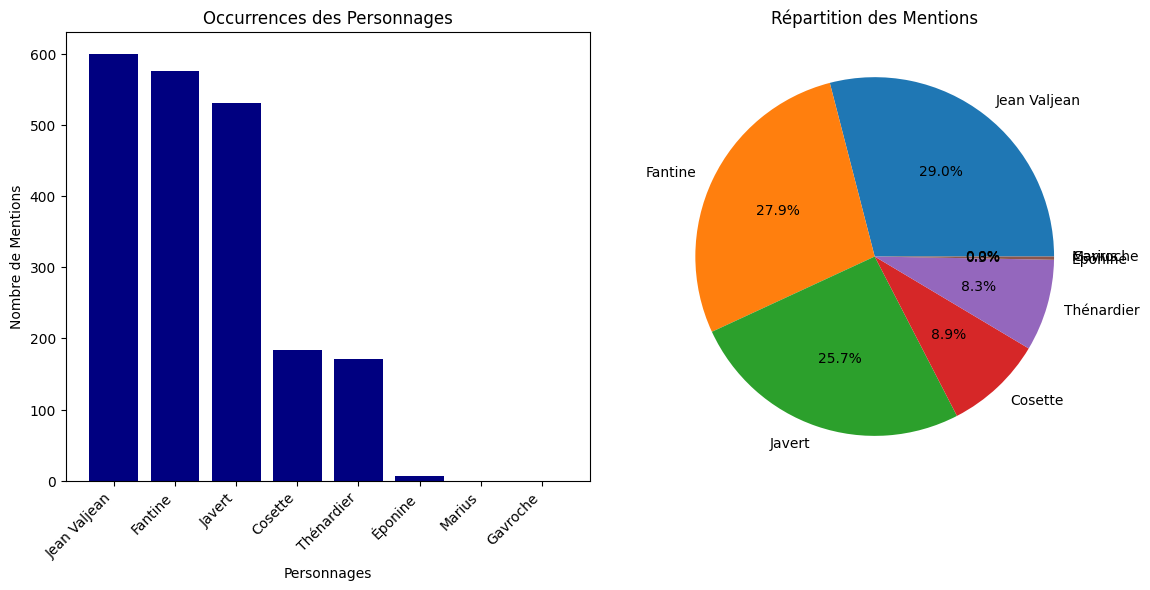

{'Jean Valjean': 600,
 'Fantine': 576,
 'Javert': 531,
 'Cosette': 183,
 'Thénardier': 171,
 'Éponine': 6,
 'Marius': 0,
 'Gavroche': 0}

In [30]:
resultats_occurrences = analyse.compter_occurrences_personnages()
analyse.visualiser_occurrences(resultats_occurrences)

### 3. Analyse de la présence par parties
Ici, le texte est analysé en fonction de différentes parties du roman. Le code divise le texte en sections et compte les mentions des personnages dans chaque partie.


<Figure size 1200x600 with 0 Axes>

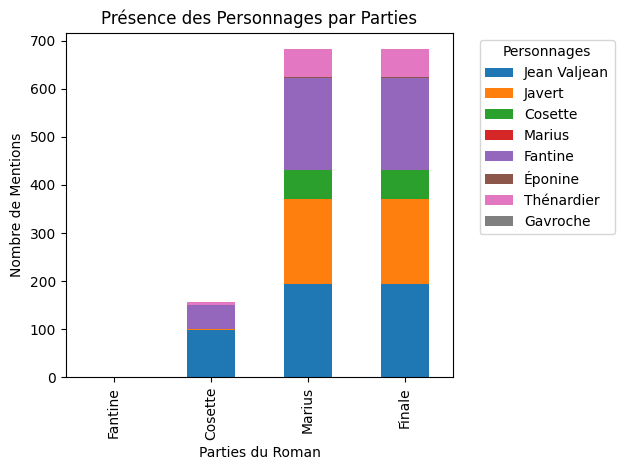

In [9]:
resultats_parties = analyser_parties_importantes(
    analyse.texte, 
    analyse.personnages_principaux
)

### 4. Analyse des co-occurrences
Cette étape analyse les co-occurrences entre les personnages, c'est-à-dire les mentions simultanées de deux personnages dans le texte. Le code génère un DataFrame des co-occurrences et une visualisation graphique.

<Figure size 1000x600 with 0 Axes>

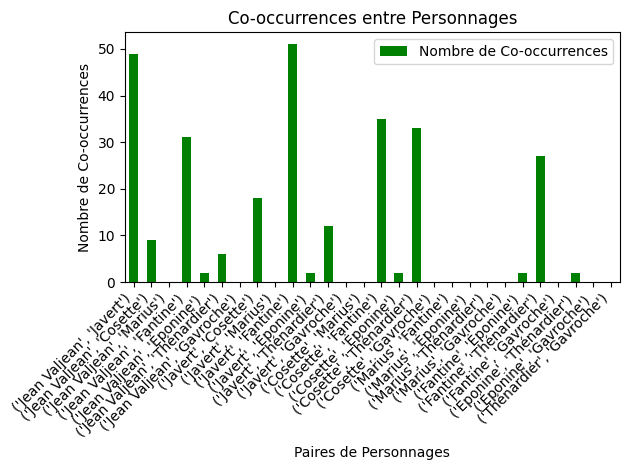

In [10]:
resultats_cooccurrences = analyser_cooccurrences(
    analyse.texte, 
    analyse.personnages_principaux
)

### 5. Exportation des résultats en fichiers CSV
Finalement, les résultats des différentes analyses sont exportés dans des fichiers CSV, permettant de sauvegarder les données pour une utilisation ultérieure.

In [11]:

csv_dir = os.path.join(output_dir, 'csv')
os.makedirs(csv_dir, exist_ok=True)

pd.DataFrame.from_dict(resultats_occurrences, orient='index', columns=['Occurrences'])\
    .to_csv(os.path.join(csv_dir, 'occurrences_personnages.csv'))

resultats_parties.to_csv(os.path.join(csv_dir, 'presence_parties.csv'), index=False)
resultats_cooccurrences.to_csv(os.path.join(csv_dir, 'cooccurrences.csv'), index=False)

print("Analyse terminée. Fichiers CSV et images générés dans output/csv/.")

Analyse terminée. Fichiers CSV et images générés dans output/csv/.


# Projet final : 2 Poursuite de l'étude des accidents routiers sur plusieurs années

Analysez l'évolution du nombre total et mortel d'accidents de 2020 à 2023, puis représentez la répartition des types d'accidents par année avec des camemberts harmonisés et des légendes explicites.

## Explication du Code

Ce code définit trois dictionnaires Python, chacun contenant des liens vers des jeux de données sur les accidents de la route en France pour les années 2023, 2022 et 2021.  

### Structure des Dictionnaires
Chaque dictionnaire (`year_data_urls_2023`, `year_data_urls_2022`, `year_data_urls_2021`) associe des catégories de données à des URLs hébergées sur **data.gouv.fr** :
- **"usagers"** : Informations sur les usagers impliqués dans les accidents.  
- **"vehicules"** : Données sur les véhicules impliqués.  
- **"lieux"** : Localisation et caractéristiques des lieux d’accidents.  
- **"caracteristiques"** : Informations générales sur les accidents (date, heure, gravité, etc.).  

## Utilisation
Ces dictionnaires permettent d’accéder facilement aux sources de données pour chaque année, facilitant ainsi l’analyse et la comparaison des accidents de la route au fil du temps.


In [12]:
year_data_urls_2023 = {
    "usagers": "https://www.data.gouv.fr/fr/datasets/r/68848e2a-28dd-4efc-9d5f-d512f7dbe66f",
    "vehicules": "https://www.data.gouv.fr/fr/datasets/r/146a42f5-19f0-4b3e-a887-5cd8fbef057b",
    "lieux": "https://www.data.gouv.fr/fr/datasets/r/8bef19bf-a5e4-46b3-b5f9-a145da4686bc",
    "caracteristiques": "https://www.data.gouv.fr/fr/datasets/r/104dbb32-704f-4e99-a71e-43563cb604f2", 
}
year_data_urls_2022 = {
    "usagers": "https://www.data.gouv.fr/fr/datasets/r/62c20524-d442-46f5-bfd8-982c59763ec8",
    "vehicules": "https://www.data.gouv.fr/fr/datasets/r/c9742921-4427-41e5-81bc-f13af8bc31a0",
    "lieux": "https://www.data.gouv.fr/fr/datasets/r/a6ef711a-1f03-44cb-921a-0ce8ec975995",
    "caracteristiques": "https://www.data.gouv.fr/fr/datasets/r/5fc299c0-4598-4c29-b74c-6a67b0cc27e7",
}
year_data_urls_2021 = {
    "usagers": "https://www.data.gouv.fr/fr/datasets/r/ba5a1956-7e82-41b7-a602-89d7dd484d7a",
    "vehicules": "https://www.data.gouv.fr/fr/datasets/r/0bb5953a-25d8-46f8-8c25-b5c2f5ba905e",
    "lieux": "https://www.data.gouv.fr/fr/datasets/r/8a4935aa-38cd-43af-bf10-0209d6d17434",
    "caracteristiques": "https://www.data.gouv.fr/fr/datasets/r/85cfdc0c-23e4-4674-9bcd-79a970d7269b",
}

## Explication du Code

Cette fonction **`load_french_traffic_accident_data`** charge les données des accidents de la route en France à partir des URLs fournies sur **data.gouv.fr**, en les convertissant en **DataFrames pandas**.

### Fonctionnement

#### 1. Paramètre
- `year_data_urls` : Un dictionnaire contenant les URLs des fichiers CSV pour une année donnée.

#### 2. Création d’un dictionnaire de DataFrames
- `dataframes = {}` : Initialise un dictionnaire vide pour stocker les données chargées.
- `file_urls` : Récupère les URLs des fichiers **"usagers"**, **"véhicules"**, **"lieux"** et **"caractéristiques"**.

#### 3. Lecture des fichiers CSV
- Une boucle `for key, url in file_urls.items():` parcourt chaque catégorie de données.
- `pd.read_csv(url, sep=";", low_memory=False)` : Charge le fichier CSV en précisant que le séparateur est `;` et en désactivant l’optimisation de mémoire pour éviter des erreurs de type.
- `df.columns = [col.lower().strip() for col in df.columns]` : Normalise les noms des colonnes (passage en minuscules et suppression des espaces).

#### 4. Gestion des erreurs
- Si un problème survient lors du chargement (`except Exception as e:`), un message d'erreur est affiché et la valeur `None` est assignée au fichier concerné.

#### 5. Retour
- La fonction retourne un dictionnaire contenant un DataFrame par catégorie de données, ou `None` en cas d’échec.


In [14]:
import pandas as pd

def load_french_traffic_accident_data(year_data_urls):
    """
    Loads the four CSV files related to French traffic accident data from data.gouv.fr into pandas DataFrames.
    """
    dataframes = {}
    file_urls = {
        "usagers": year_data_urls["usagers"],
        "vehicules": year_data_urls["vehicules"],
        "lieux": year_data_urls["lieux"],
        "caracteristiques": year_data_urls["caracteristiques"],
    }

    for key, url in file_urls.items():
        try:
            # Utiliser low_memory=False pour gérer les types mixtes
            # Spécifier explicitement les types de colonnes si nécessaire
            df = pd.read_csv(url, sep=";", low_memory=False)
            
            # Normaliser les noms de colonnes (enlever les espaces, mettre en minuscules)
            df.columns = [col.lower().strip() for col in df.columns]
            
            dataframes[key] = df
        except Exception as e:
            print(f"Erreur lors du chargement des données depuis {url}: {e}")
            dataframes[key] = None

    return dataframes

## Explication du Code

Cette fonction **`analyze_accidents`** analyse les données d'accidents pour une année donnée en calculant :
1. **Le nombre total d’accidents**.
2. **Le nombre d’accidents mortels** (accidents avec au moins un décès).

### Fonctionnement

#### 1. Vérification des données
- Si `year_data` est vide ou contient des `None`, la fonction retourne `(None, None)`.

#### 2. Récupération des DataFrames
- `caracteristiques` : Contient les informations générales sur les accidents.
- `usagers` : Contient les informations sur les personnes impliquées.

#### 3. Identification de la colonne contenant le numéro d’accident
- Liste de noms possibles : `['num_acc', 'numacc', 'numaccident', 'num_accident', 'accident_id']`.
- La fonction cherche la première occurrence valide dans `caracteristiques`.
- Si la colonne n'est pas trouvée, un message d'erreur s'affiche et la fonction retourne `(None, None)`.

#### 4. Gestion des incohérences entre `caracteristiques` et `usagers`
- Si `caracteristiques` utilise `accident_id` mais `usagers` utilise `num_acc`, la fonction ajuste automatiquement.

#### 5. Identification de la colonne de gravité
- Liste de noms possibles : `['grav', 'gravite', 'gravité']`.
- Si aucune colonne n’est trouvée, un message d'erreur s'affiche et la fonction retourne `(total_accidents, None)`.

#### 6. Calcul des accidents mortels
- Filtrage des usagers où `grav_col == 2` (indiquant un décès).
- Comptage du nombre unique d’accidents concernés.

### Retour
- **`total_accidents`** : Nombre total d’accidents uniques.
- **`accidents_mortels`** : Nombre d’accidents avec au moins un décès.


In [15]:
def analyze_accidents(year_data):
    """
    Analyze accident data for a specific year.
    """
    if not year_data or any(df is None for df in year_data.values()):
        return None, None
    
    # Vérifier les noms de colonnes possibles
    caracteristiques = year_data["caracteristiques"]
    usagers = year_data["usagers"]

    # Diverses variantes possibles pour le numéro d'accident
    num_acc_columns = ['num_acc', 'numacc', 'numaccident', 'num_accident', 'accident_id']
    
    # Trouver la colonne correcte
    num_acc_col = next((col for col in num_acc_columns if col in caracteristiques.columns), None)
    
    if not num_acc_col:
        print("Impossible de trouver la colonne du numéro d'accident")
        return None, None

    # Si la colonne est différente dans caracteristiques et usagers, ajuster
    if num_acc_col == 'accident_id':
        total_accidents = caracteristiques[num_acc_col].nunique()
        
        # Pour les usagers, vérifier s'il y a une correspondance avec num_acc
        if 'num_acc' in usagers.columns:
            num_acc_usagers_col = 'num_acc'
        else:
            # Si aucune colonne de numéro d'accident n'est trouvée dans usagers
            num_acc_usagers_col = next((col for col in num_acc_columns if col in usagers.columns), None)
        
        if not num_acc_usagers_col:
            print("Impossible de trouver la colonne du numéro d'accident dans les usagers")
            return total_accidents, None
    else:
        total_accidents = caracteristiques[num_acc_col].nunique()
        num_acc_usagers_col = num_acc_col

    # Trouver la colonne de gravité
    grav_columns = ['grav', 'gravite', 'gravité']
    grav_col = next((col for col in grav_columns if col in usagers.columns), None)
    
    if not grav_col:
        print("Impossible de trouver la colonne de gravité")
        return total_accidents, None

    # Compter les accidents avec au moins un décès
    accidents_mortels = usagers[usagers[grav_col] == 2][num_acc_usagers_col].nunique()
    
    return total_accidents, accidents_mortels

## Explication du Code

Ce code charge les données d’accidents pour **2021, 2022 et 2023** et les stocke dans un tableau.

### 1. Chargement des données
- `load_french_traffic_accident_data(year_data_urls_202X)`: Charge les données depuis **data.gouv.fr** en DataFrames.

### 2. Stockage des résultats
- `years_data` : Liste de tuples associant chaque année à ses données, facilitant l’analyse comparative.


In [16]:
# Charger et analyser les données
accident_data_2023 = load_french_traffic_accident_data(year_data_urls_2023)
accident_data_2022 = load_french_traffic_accident_data(year_data_urls_2022)
accident_data_2021 = load_french_traffic_accident_data(year_data_urls_2021)

# Créer un tableau des résultats
years_data = [
    ("2021", accident_data_2021),
    ("2022", accident_data_2022),
    ("2023", accident_data_2023)
]

## Explication du Code

Ce code affiche un récapitulatif des accidents de la route par année.

### 1. Affichage
- Titre et colonnes : **Année**, **Total accidents**, **Accidents mortels**.

### 2. Traitement
- Pour chaque année, il analyse les données et affiche les résultats ou une erreur si les données sont manquantes.


In [17]:
print("Analyse des accidents de la route :")
print("-" * 50)
print(f"{'Année':<8} {'Total accidents':<20} {'Accidents mortels':<20}")
print("-" * 50)

for year, data in years_data:
    try:
        total, mortels = analyze_accidents(data)
        if total is not None:
            print(f"{year:<8} {total:<20} {mortels:<20}")
        else:
            print(f"{year:<8} Données non disponibles")
    except Exception as e:
        print(f"{year:<8} Erreur de traitement : {e}")

Analyse des accidents de la route :
--------------------------------------------------
Année    Total accidents      Accidents mortels   
--------------------------------------------------
2021     56518                3032                
2022     55302                3337                
2023     54822                3203                


## Explication du Code

Ce code définit un dictionnaire pour traduire les **codes de gravité** en labels lisibles et associe chaque type de gravité à une couleur spécifique.

### 1. Traduction des gravités
- `gravite_labels` : Dictionnaire associant chaque code de gravité (1 à 4) à un libellé :
  - 1 : 'Indemne'
  - 2 : 'Tué'
  - 3 : 'Blessé hospitalisé'
  - 4 : 'Blessé léger'

### 2. Palette de couleurs
- `color_palette` : Dictionnaire associant chaque code de gravité à une couleur spécifique pour l'affichage graphique.


In [18]:
# Dictionnaire de traduction pour les types de gravité
gravite_labels = {
        1: 'Indemne',
        2: 'Tué',
        3: 'Blessé hospitalisé',
        4: 'Blessé léger'
}

# Palette de couleurs harmonisée
color_palette = {
        1: '#66c2a5',  # Indemne - vert d'eau
        2: '#fc8d62',  # Tué - rouge corail
        3: '#8da0cb',  # Blessé hospitalisé - bleu gris
        4: '#e78ac3'   # Blessé léger - rose
}

## Explication du Code

Cette fonction génère des **camemberts** montrant la répartition des types de gravité des accidents par année et les sauvegarde dans un fichier.

### 1. Création du dossier de sortie
- `output_dir = 'output/img'` : Définir le dossier pour enregistrer l'image.
- `os.makedirs(output_dir, exist_ok=True)` : Créer le dossier si nécessaire.

### 2. Configuration de la mise en page
- `fig, axes = plt.subplots(1, 3, figsize=(18, 6))` : Créer une figure avec 3 sous-graphes (pour 3 années).
- `fig.suptitle()` : Ajouter un titre global au graphique.

### 3. Boucle sur les années
- Pour chaque année dans `years_data`, on vérifie si les données sont valides.
- Les types de gravité sont comptabilisés avec `value_counts()`.

### 4. Préparation des données pour le camembert
- `gravite_counts` : Compte les occurrences de chaque type de gravité.
- `labels`, `sizes`, `colors` : Crée les listes pour les étiquettes, tailles et couleurs des camemberts.

### 5. Création des camemberts
- `axes[i].pie()` : Génère un camembert pour chaque année avec les tailles et couleurs associées.
- `axes[i].set_title()` : Ajoute un titre pour chaque graphique (année).

### 6. Sauvegarde et affichage
- Le graphique est sauvegardé dans `output_path`.
- `plt.show()` : Affiche le graphique à l'écran.


In [19]:

import matplotlib.pyplot as plt
import os


def create_accident_severity_pie_charts():
    # Créer le dossier de sortie s'il n'existe pas
    output_dir = 'output/img'
    os.makedirs(output_dir, exist_ok=True)
    
    # Configurer la mise en page
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Répartition des Types de Gravité des Accidents par Année', fontsize=16)
    
    for i, (year, data) in enumerate(years_data):
        # Vérifier que les données sont valides
        if not data or 'usagers' not in data:
            print(f"Données non disponibles pour {year}")
            continue
        
        # Compter les types de gravité
        gravite_counts = data['usagers']['grav'].value_counts()
        
        # Préparer les données pour le camembert
        labels = []
        sizes = []
        colors = []
        
        for key, value in gravite_counts.items():
            # N'inclure que les types de gravité définis dans le dictionnaire
            if key in gravite_labels:
                labels.append(gravite_labels[key])
                sizes.append(value)
                colors.append(color_palette[key])
        
        # Créer le camembert
        axes[i].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f'Année {year}')
    
    plt.tight_layout()
    
    # Sauvegarder le graphique
    output_path = os.path.join(output_dir, 'accident_severity_pie_charts.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Graphique sauvegardé dans {output_path}")
    
    # Afficher le graphique
    plt.show()

Graphique sauvegardé dans output/img\accident_severity_pie_charts.png


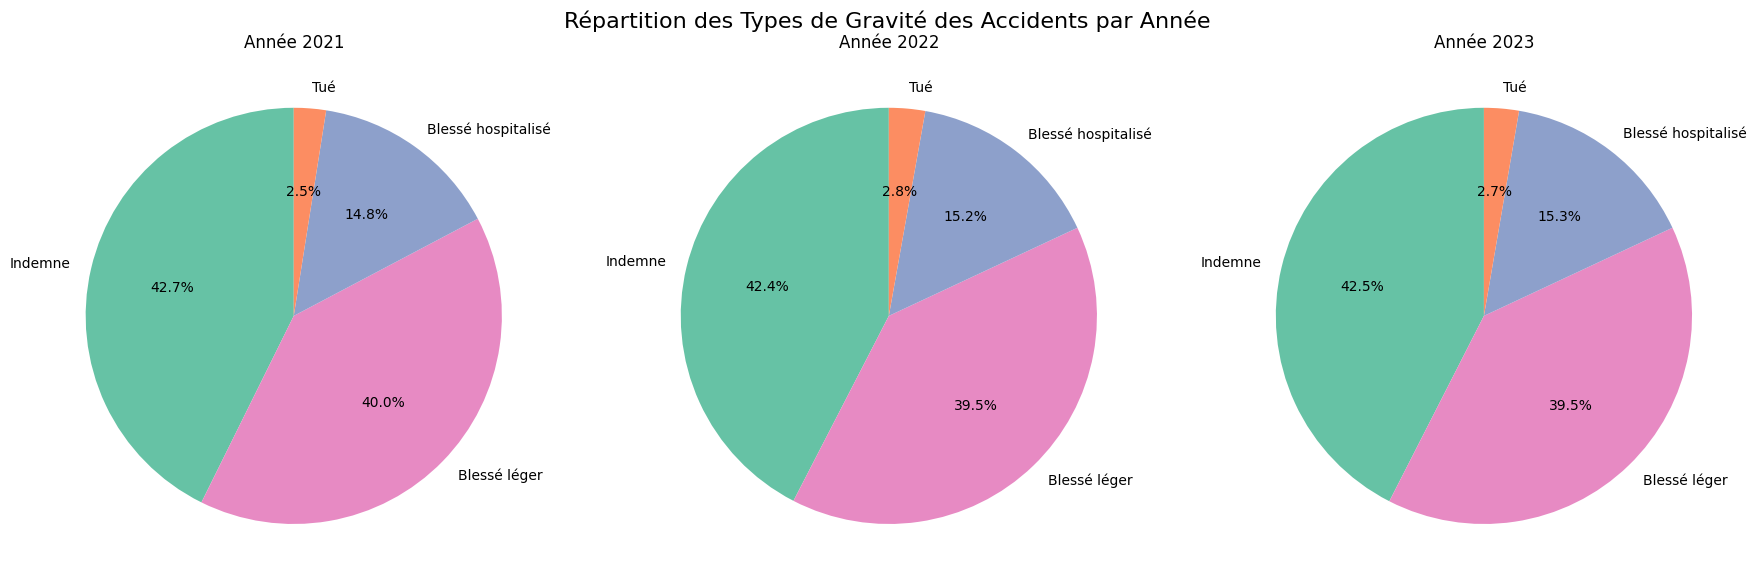

In [20]:
# Exécuter la fonction
create_accident_severity_pie_charts()

# Option 2

Cette option consiste à identifier les types d'accidents en fonction des véhicules impliqués. Pour cela, vous allez :

- Utiliser la commande **groupby** afin de regrouper les données par type d'implication (par exemple, les accidents impliquant deux véhicules).
- Détecter les propriétés distinctes pour chaque groupe, comme la gravité des accidents.
- Comparer, par exemple, la gravité et la fréquence des accidents **voiture-voiture**, **voiture-moto**, **camion-moto**, etc.


## Explication de code

Ce code définit deux dictionnaires pour traduire :

- **vehicle_translations** : Associe des codes numériques à des types de véhicules (ex. 1 → Bicyclette, 4 → Voiture légère).
- **severity_translation** : Associe des codes numériques à des niveaux de gravité (ex. 1 → Indemne, 2 → Tué).


In [21]:
# Vehicle type translation
vehicle_translations = {
    1: 'Bicyclette',
    2: 'Cyclomoteur <50cc',
    3: 'Motocyclette >50cc',
    4: 'Voiture légère',
    5: 'Camionnette/Utilitaire',
    6: 'Poids lourd',
    7: 'Transport en commun',
    8: 'Autre véhicule',
    9: 'Piéton',
    10: 'Véhicule non motorisé'
}

# Severity translation
severity_translation = {
    1: 'Indemne',
    2: 'Tué',
    3: 'Blessé hospitalisé',
    4: 'Blessé léger'
}

## Explication de la Méthode

La fonction **analyze_vehicle_accidents** analyse les accidents de véhicules sur plusieurs années en :

- **Traitant les données** : Pour chaque année, elle vérifie et récupère les DataFrames des véhicules et des usagers.
- **Identifiant les accidents** : Elle repère la colonne d'identifiant d'accident parmi plusieurs variantes, puis normalise la catégorie de véhicule (colonne "catv").
- **Regroupant et filtrant** : Elle groupe les véhicules par accident, sélectionne uniquement les accidents impliquant exactement 2 véhicules, et traduit les codes en libellés via un dictionnaire externe.
- **Comptant les combinaisons** : Elle compte les différentes combinaisons de véhicules et les associe à leur année.
- **Analysons la gravité** : Elle traduit et compte les niveaux de gravité des accidents à partir des données des usagers.
- **Visualisant les résultats** : Elle affiche un graphique en barres pour les 10 combinaisons de véhicules les plus fréquentes et un graphique en camembert pour la répartition des niveaux de gravité, puis imprime un résumé des résultats.

Enfin, la fonction retourne les données combinées pour les combinaisons de véhicules et la distribution de la gravité.


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_vehicle_accidents(years_data):
    """
    Analyze accident characteristics by vehicle types across multiple years
    """
    all_vehicle_data = []
    all_severity_data = []
    
    
    for year, data in years_data:
        if not data or 'vehicules' not in data or 'usagers' not in data:
            print(f"Données non disponibles pour {year}")
            continue
        
        # Merge vehicules and usagers data
        vehicules = data['vehicules']
        usagers = data['usagers']
        
        # Identify common accident ID column
        num_acc_cols = ['num_acc', 'numacc', 'numaccident', 'num_accident', 'accident_id']
        num_acc_col = next((col for col in num_acc_cols if col in vehicules.columns), None)
        
        if not num_acc_col:
            print(f"Impossible de trouver la colonne de numéro d'accident pour {year}")
            continue
        
        # Ensure 'catv' column exists and has valid data
        if 'catv' not in vehicules.columns:
            print(f"Colonne 'catv' non trouvée pour {year}")
            continue
        
        # Normalize vehicle categories
        vehicules['catv'] = vehicules['catv'].fillna(8).astype(int)
        
        # Get vehicle types and count per accident
        vehicle_combinations = vehicules.groupby(num_acc_col)['catv'].apply(list).reset_index()
        
        # Filter for accidents with exactly 2 vehicles
        two_vehicle_accidents = vehicle_combinations[vehicle_combinations['catv'].apply(len) == 2]
        
        # Translate vehicle combinations
        two_vehicle_accidents['vehicle_combo'] = two_vehicle_accidents['catv'].apply(
            lambda x: ' + '.join(vehicle_translations.get(v, f'Véhicule {v}') for v in sorted(x))
        )
        
        # Count combinations
        combo_counts = two_vehicle_accidents['vehicle_combo'].value_counts()
        
        # Add year column to combo counts
        combo_counts_with_year = pd.DataFrame({
            'vehicle_combo': combo_counts.index, 
            'count': combo_counts.values, 
            'year': year
        })
        all_vehicle_data.append(combo_counts_with_year)
        
        # Severity analysis
        severity_col = next((col for col in ['grav', 'gravite', 'gravité'] if col in usagers.columns), None)
        
        if severity_col:
            severity_counts = usagers[severity_col].map(severity_translation).value_counts()
            severity_counts_with_year = pd.DataFrame({
                'severity': severity_counts.index, 
                'count': severity_counts.values, 
                'year': year
            })
            all_severity_data.append(severity_counts_with_year)
    
    # Combine data from all years
    if all_vehicle_data and all_severity_data:
        # Visualize results
        plt.figure(figsize=(15, 10))
        
        # Combinations plot
        plt.subplot(2, 1, 1)
        combined_vehicle_data = pd.concat(all_vehicle_data)
        top_combos = combined_vehicle_data.groupby('vehicle_combo')['count'].sum().nlargest(10)
        top_combos.plot(kind='bar')
        plt.title('Top 10 Combinaisons de Véhicules (2021-2023)')
        plt.xlabel('Combinaisons de Véhicules')
        plt.ylabel('Nombre d\'Accidents')
        plt.xticks(rotation=45, ha='right')
        
        # Severity plot
        plt.subplot(2, 1, 2)
        combined_severity_data = pd.concat(all_severity_data)
        severity_totals = combined_severity_data.groupby('severity')['count'].sum()
        severity_totals.plot(kind='pie', autopct='%1.1f%%')
        plt.title('Distribution de la Gravité des Accidents (2021-2023)')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("\nAnalyse Globale des Accidents (2021-2023):")
        print("-" * 50)
        print("Top Combinaisons de Véhicules:")
        print(top_combos)
        print("\nDistribution de Gravité:")
        print(severity_totals)
    
    return combined_vehicle_data, combined_severity_data

C:\Users\MarcAWAD\AppData\Local\Temp\ipykernel_15568\4152363442.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_vehicle_accidents['vehicle_combo'] = two_vehicle_accidents['catv'].apply(
C:\Users\MarcAWAD\AppData\Local\Temp\ipykernel_15568\4152363442.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_vehicle_accidents['vehicle_combo'] = two_vehicle_accidents['catv'].apply(
C:\Users\MarcAWAD\AppData\Local\Temp\ipykernel_15568\4152363442.py:44: SettingWithCopyWarning: 
A value is trying to be se

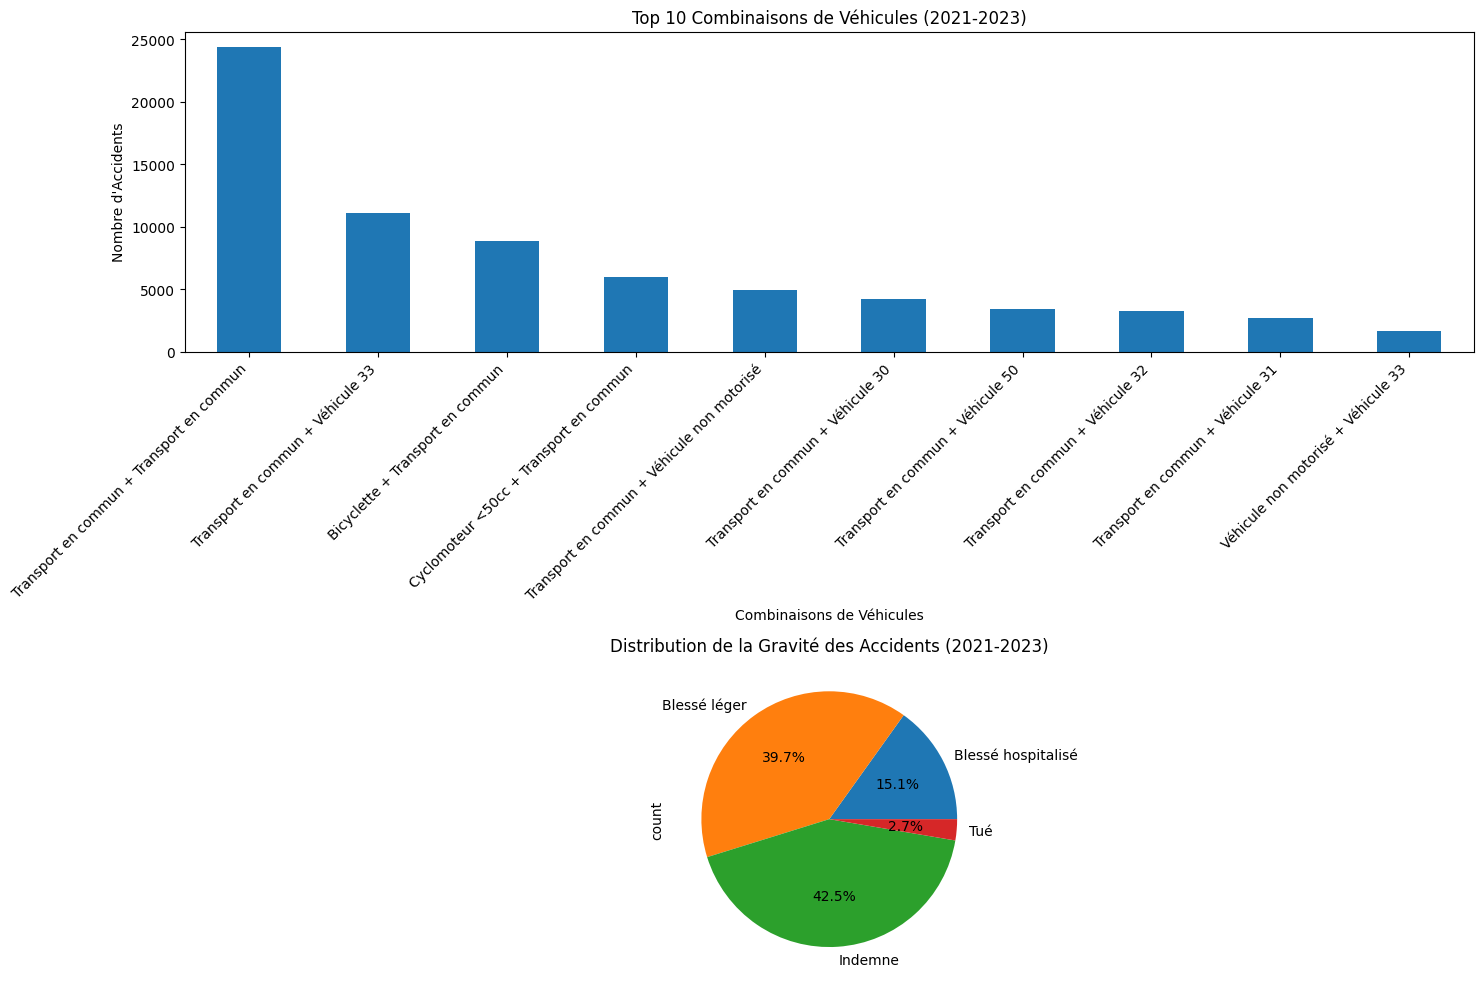


Analyse Globale des Accidents (2021-2023):
--------------------------------------------------
Top Combinaisons de Véhicules:
vehicle_combo
Transport en commun + Transport en commun      24367
Transport en commun + Véhicule 33              11052
Bicyclette + Transport en commun                8819
Cyclomoteur <50cc + Transport en commun         5996
Transport en commun + Véhicule non motorisé     4953
Transport en commun + Véhicule 30               4187
Transport en commun + Véhicule 50               3370
Transport en commun + Véhicule 32               3225
Transport en commun + Véhicule 31               2707
Véhicule non motorisé + Véhicule 33             1645
Name: count, dtype: int64

Distribution de Gravité:
severity
Blessé hospitalisé     57624
Blessé léger          151317
Indemne               162172
Tué                    10167
Name: count, dtype: int64


In [23]:
# Execute the analysis
try:
    top_combinations, severity_distribution = analyze_vehicle_accidents(years_data)
except Exception as e:
    print(f"Une erreur s'est produite : {e}")

## Option  1 : Analyse des Accidents de Scooter par Heure

Ce code permet d'analyser les accidents de scooter par heure de la journée en utilisant des données sur les véhicules et les caractéristiques des accidents.

> **Note importante** : Le code présenté ne fonctionne pas correctement en raison de certaines erreurs ou problèmes dans les données d'entrée. Les erreurs spécifiques peuvent inclure des colonnes manquantes, des formats de date incorrects, ou des incohérences dans les identifiants d'accidents. Des ajustements supplémentaires seront nécessaires pour garantir son bon fonctionnement.


#### 1. Vérification des Données
Le code vérifie que les données nécessaires (`vehicules` et `caracteristiques`) sont présentes dans `year_data`.

#### 2. Filtrage des Accidents de Scooter
Il filtre les accidents impliquant des scooters (catégorie 30) en fonction des identifiants des accidents.

#### 3. Vérification des Colonnes
Les colonnes essentielles (`jour`, `mois`, `an`, `hrmn`) sont vérifiées dans les données des accidents.

#### 4. Création de la Colonne Datetime
Les colonnes de date et heure sont combinées pour créer une nouvelle colonne `datetime` représentant le moment de chaque accident.

#### 5. Extraction de l'Heure
L'heure de l'accident est extraite de la colonne `datetime` et stockée dans une nouvelle colonne `hour`.

#### 6. Comptage des Accidents par Heure
Le nombre d'accidents par heure est compté, puis visualisé sous forme de graphique à barres.

#### 7. Visualisation
Le code génère un graphique représentant le nombre d'accidents de scooter pour chaque heure de la journée.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_scooter_accidents_by_hour(year_data):
    # Vérification des données
    if not year_data or 'vehicules' not in year_data or 'caracteristiques' not in year_data:
        print("Données insuffisantes pour l'analyse.")
        return None

    vehicules = year_data['vehicules']
    caracteristiques = year_data['caracteristiques']

    # Filtrer les accidents de scooter
    num_acc_cols = ['num_acc', 'num_accident', 'numaccident']
    num_acc_col = next((col for col in num_acc_cols if col in vehicules.columns), None)
    if not num_acc_col:
        print("Colonne d'identifiant d'accident non trouvée dans 'vehicules'.")
        return None

    scooter_vehicules = vehicules[vehicules['catv'] == 30]
    scooter_ids = scooter_vehicules[num_acc_col].unique()
    scooter_accidents = caracteristiques[caracteristiques[num_acc_col].isin(scooter_ids)].copy()

    # Vérification des colonnes nécessaires
    required_cols = ['jour', 'mois', 'an', 'hrmn']
    if not all(col in scooter_accidents.columns for col in required_cols):
        print("Colonnes 'jour', 'mois', 'an' et/ou 'hrmn' non trouvées dans 'caracteristiques'.")
        return None

    # S'assurer que 'hrmn' a 4 chiffres
    scooter_accidents['hrmn'] = scooter_accidents['hrmn'].astype(str).str.zfill(4)

    # Créer la colonne datetime
    scooter_accidents['datetime'] = pd.to_datetime(
        scooter_accidents['jour'].astype(str) + '-' +
        scooter_accidents['mois'].astype(str) + '-' +
        scooter_accidents['an'].astype(str) + ' ' +
        scooter_accidents['hrmn'],
        format='%d-%m-%Y %H%M', errors='coerce'
    )

    # Vérifiez s'il y a des NaT dans la colonne datetime
    if scooter_accidents['datetime'].isna().any():
        print(f"Attention, il y a {scooter_accidents['datetime'].isna().sum()} valeurs NaT dans 'datetime'.")
        # Afficher les lignes avec des valeurs NaT
        problematic_rows = scooter_accidents[scooter_accidents['datetime'].isna()]
        print("Lignes avec des valeurs NaT :")
        print(problematic_rows)

    # Extraire l'heure de la journée
    scooter_accidents['hour'] = scooter_accidents['datetime'].dt.hour

    # Compter le nombre d'accidents par heure
    accidents_by_hour = scooter_accidents['hour'].value_counts().sort_index()

    # Vérifiez si accidents_by_hour contient des données avant de tracer
    if accidents_by_hour.empty:
        print("Aucun accident n'a été enregistré par heure.")
        return None

    # Visualiser les résultats
    plt.figure(figsize=(10, 6))
    accidents_by_hour.plot(kind='bar')
    plt.title("Accidents de scooter par heure de la journée")
    plt.xlabel("Heure")
    plt.ylabel("Nombre d'accidents")
    plt.xticks(rotation=0)
    plt.show()

    return accidents_by_hour

# Exemple d'utilisation pour une année (exemple avec accident_data_2021)
accidents_by_hour_2021 = analyze_scooter_accidents_by_hour(accident_data_2021)
if accidents_by_hour_2021 is not None:
    print(accidents_by_hour_2021)

Attention, il y a 3297 valeurs NaT dans 'datetime'.
Lignes avec des valeurs NaT :
            num_acc  jour  mois    an   hrmn  lum  dep    com  agg  int  atm  \
55     202100000056    11    12  2021  04:10    3  974  97416    1    1    1   
81     202100000082    14    12  2021  16:35    1   78  78172    2    2    1   
102    202100000103     2     4  2021  19:28    1   35  35095    2    9    1   
109    202100000110    18    12  2021  15:20    1   74  74010    2    1    1   
120    202100000121    30    11  2021  18:15    5   19  19031    2    1    1   
...             ...   ...   ...   ...    ...  ...  ...    ...  ...  ...  ...   
56396  202100056397     1     1  2021  17:25    2   71  71153    2    2    1   
56409  202100056410     1     1  2021  21:10    5   29  29019    2    3    1   
56417  202100056418     1     1  2021  20:55    5   75  75119    2    2    1   
56424  202100056425     1     1  2021  19:20    5   75  75110    2    1    1   
56443  202100056444     1     1  2021 

# Option : Arbres Décisionnels sur un Jeu de Données Libre

## 1. Introduction  
Dans ce projet, nous allons appliquer des **arbres décisionnels** à un jeu de données libre afin d'analyser et de prédire certaines tendances.  

## 2. Choix du Jeu de Données  
Le jeu de données utilisé provient de [INSEE] ([Lien vers le dataset](https://www.data.gouv.fr/fr/datasets/population/)).  
Il contient des informations sur les **naissances, les mariages et les décés**.  

## 3. Objectif de l'Analyse  
L'objectif est de :  
- Explorer et comprendre les données.  
- Prétraiter les données (gestion des valeurs manquantes, encodage, etc.).  


In [11]:
import os
import pandas as pd

# Définition du dossier contenant les fichiers
CHEMIN_FICHIER_MARIAGE = "mariage_csv_jeu_donnee_libre"

# Dictionnaire contenant les fichiers de mariage par année
fichiers = {
    "2021": "mar2021.csv",
    "2020": "FD_MAR_2020.csv",
    "2019": "FD_MAR_2019.csv",
    "2018": "FD_MAR_2018.csv",
    "2017": "etatcivil2017_mar2017.csv",
}

# Chargement des fichiers dans un dictionnaire de DataFrames
df_mariage = {}
for annee, fichier in fichiers.items():
    chemin_fichier = os.path.join(CHEMIN_FICHIER_MARIAGE, fichier)
    try:
        df_mariage[annee] = pd.read_csv(chemin_fichier, sep=";", dtype=str, low_memory=False)
        print(f"Données de {annee} chargées avec succès. {df_mariage[annee].shape[0]} lignes.")
    except FileNotFoundError:
        print(f"Fichier {fichier} introuvable.")
    except pd.errors.EmptyDataError:
        print(f"Fichier {fichier} vide.")
    except Exception as e:
        print(f"Erreur lors de la lecture de {fichier} : {e}")

print(df_mariage["2021"].head())


Données de 2021 chargées avec succès. 218819 lignes.
Données de 2020 chargées avec succès. 154581 lignes.
Données de 2019 chargées avec succès. 224740 lignes.
Données de 2018 chargées avec succès. 234735 lignes.
Données de 2017 chargées avec succès. 231338 lignes.
   AMAR ANAIS1 ANAIS2 DEPDOM DEPMAR DEPNAIS1 DEPNAIS2 ETAMAT1 ETAMAT2 INDNAT1  \
0  2021   1988   1989     99     01       01       01       1       1       2   
1  2021   1978   1984     99     01       69       93       1       1       1   
2  2021   1987   1992     99     01       99       71       1       1       2   
3  2021   1985   1992     99     01       74       99       4       1       1   
4  2021   1991   1993     99     01       99       69       1       1       2   

  INDNAT2 JSEMAINE MMAR NBENFCOM SEXE1 SEXE2 TUCOM TUDOM  
0       1        6   07        O     M     F   NaN     9  
1       1        6   07        N     M     F   NaN     9  
2       1        6   07        N     M     F   NaN     9  
3       2   